# MCMQMC 2024 Tutorial
## Quasi-Monte Carlo Methods:  What, Why, and How?
### Fred J. Hickernell

This demo makes use of our QMCPy software package.  See [qmcpy.org](www.qmcpy.org) for more details.

### Some LaTeX macros (hidden in math mode)
$
\newcommand{\vh}{\boldsymbol{h}}
\newcommand{\vt}{\boldsymbol{t}}
\newcommand{\vx}{\boldsymbol{x}}
\newcommand{\vX}{\boldsymbol{X}}
\newcommand{\cf}{\mathcal{F}}
\newcommand{\cu}{\mathcal{U}}
\newcommand{\dif}{\mathrm{d}}
\newcommand{\Ex}{\mathbb{E}}
\DeclareMathOperator{\disc}{disc}
\newcommand{\norm}[2][{}]{{\left \lVert #2 \right \rVert}_{#1}}
$

#### If are running this notebook in on colab, replace False in the next cell by True

In [1]:
if False:  #Running on colab?
    !sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended
    !sudo apt install cm-super
    !pip install git+https://github.com/QMCSoftware/QMCSoftware.git@MCQMC2024

### Import needed packages

In [2]:
import matplotlib.pyplot as plt
import math
import numpy as np
import scipy as sp
import qmcpy as qp
#from scipy import stats
#from copy import deepcopy
import time
import pickle
figpath = 'MCQMC2024DataFigures/' #this path sends the figures to the directory that you want
savefigs = True  #save the figures on your disk if True
imgfrmt = 'pdf' #kind of format to save figures as
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']  #get the color cycle
[py_blue, py_orange, py_green, py_red] = color_cycle[0:4]
font_family = "serif"
plt.rcParams["font.family"] = font_family
plt.rcParams["mathtext.fontset"] = "dejavuserif"
plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)

# for plotting
blue_symbol = {"color" : py_blue,
               "marker" : ".",
               "markersize" : 15,
               "linestyle" : ""
               }
orange_symbol = {"color" : py_orange,
               "marker" : "d",
               "markersize" : 7,
               "linestyle" : ""
               }
green_symbol = {"color" : py_green,
               "marker" : "s",
               "markersize" : 7,
               "linestyle" : ""
               }

symbo_args=[blue_symbol,orange_symbol,green_symbol]

## Keister illustrative example

Consider the integral 
$$
	I = \int_{\mathbb{R}^d} \cos(\lVert \boldsymbol{t} \rVert) \exp(-\lVert \boldsymbol{t} \rVert^2) \, \mathrm{d} \boldsymbol{t},
$$
where $\lVert  \boldsymbol{t} \rVert := \sqrt{t_1^2 + \cdots + t_d^2}$.  This may be thought of as the expectation of $Y := g(\boldsymbol{T}) := \pi^{d/2} \cos(\lVert \boldsymbol{T} \rVert)$, where $T_1, \ldots, T_d$ are IID Gaussian random variables with zero mean and variance $1/2$, i.e., $\boldsymbol{T} \sim \mathcal{N}(\boldsymbol{0},\mathsf{I}/2)$:
$$
	I = \int_{\mathbb{R}^d} \underbrace{\pi^{d/2} \cos(\lVert  \boldsymbol{t} \rVert)}_{=:g( \boldsymbol{t})} \cdot \underbrace{\frac{\exp(-\lVert  \boldsymbol{t} \rVert^2)}{\pi^{d/2}}}_{\text{density of } \mathcal{N}(\boldsymbol{0},\mathsf{I}/2)} \, \mathrm{d} \boldsymbol{t}  = \mathbb{E}(Y) = \mathbb{E}(Y)[g(T)].
$$

We perform a variable transformation $\boldsymbol{t}  = \sqrt{2}(\Phi^{-1}(x_1), \ldots, \Phi^{-1}(x_d))$, where is $\Phi$ is the cumulative distribution function of the standard Gaussian random variable.  This reimagines the integral $I$ as the expectation of a function, $f$, of a standard uniform random variable:
$$
\begin{aligned}
	I &= \int_{[0,1]^d} \underbrace{\pi^{d/2} \cos\Bigl (\sqrt{2} \bigl \lVert \bigl( \Phi^{-1}(x_1), \ldots, \Phi^{-1}(x_d)\bigr) \bigr\rVert \Bigr)}_{=:f(\boldsymbol{x})} \, \mathrm{d} \boldsymbol{x} \\
	&= \mathbb{E}(Y) 
	= \mathbb{E}[f(\boldsymbol{X})], \qquad \boldsymbol{X} \sim \mathcal{U}[0,1]^d.
\end{aligned}
$$

### Calculate approximations to this integral using grid sampling, simple Monte Carlo, and quasi-Monte Carlo

In [3]:
d = 6  #the dimension we will try
keister_net = qp.Keister(qp.DigitalNetB2(d))  #use the built-in Keister function
true_value = keister_net.exact_integ(d) #the true value can be calculated as a one-dimensional integral
print("For d =",d,", the value of the integral =",true_value)

For d = 6 , the value of the integral = -2.327303729297949


In [4]:
def make_grid(d=3,nper=2):  #this function creates a nper^d x d matrix of grid points
    xpts = np.linspace(1/(2*nper), 1.0-1/(2*nper), nper)  #array of coordinate values
    xgrid = xpts  #initial grid
    n = nper  #initial length of grid
    for ii in range(1,d):
        xgrid0 = xgrid  #store the old grid
        xgrid = np.vstack((xgrid0,xpts[0]*np.ones((1,n))))  #stack the next coordinate
        for jj in range(1,nper):
            xgrid = np.hstack((xgrid,np.vstack((xgrid0,xpts[jj]*np.ones((1,n))))))
        n = n*nper  #update the length of the grid
    return xgrid.T  #take the transpose to that coordinates are columns


In [5]:
#Parameters for the calculations below
m_max = 24  #log_2 of the maximum number of samples
n_rep = 50  #number of replications for (q)MC
n_max = 2**m_max  #maximum number of samples
nn_mc = 50  #number of different MC sample sizes
n_grid = (np.arange(1,np.floor(n_max**(1./d)))**d).astype(int)  #vector of grid sample sizes
n_mc = np.floor(2**np.linspace(0,m_max,nn_mc)).astype(int)  #vector of MC sample sizes
n_qmc = 2**np.arange(0,m_max+1,dtype = int)  #vector of qMC sample sizes

### Skip this time-consuming block if the Keister computations have already been done

In [6]:
#function to compute the relative error of the Keister example for a node set x
def keister_err(x,n_val):
    y = keister_net.g(sp.stats.norm.ppf(x)/np.sqrt(2))
    sample_avg = y.cumsum()[n_val-1]/n_val
    return np.abs(1 - sample_avg/true_value)

#compute errors for grids
err_grid = np.zeros_like(n_grid,dtype = float)
for ii, n in enumerate(n_grid):
    err_grid[ii] = keister_err(make_grid(d,ii+1),n) 
#print(err_grid)

#compute errors for (q)MC
err_mc = np.zeros([len(n_mc),n_rep])
err_qmc = np.zeros([m_max+1,n_rep])
print("Replication")
for jj in range(n_rep):
    print(f"{jj},", end = " ", flush = True)
    iid_pts = qp.IIDStdUniform(d).gen_samples(n_mc[-1])
    net_pts = qp.DigitalNetB2(d).gen_samples(n_qmc[-1])
    # Check where the values are 0 or 1
    mask = (net_pts == 0.) | (net_pts == 1.) #check for  bad points
    if np.any(mask):  #if there are any, print them
        bad_values = net_pts[mask]
        print("BAD VALUES:", bad_values)
    err_mc[:,jj] = keister_err(iid_pts,n_mc) 
    err_qmc[:,jj] = keister_err(net_pts,n_qmc) 
err_mc_avg = err_mc.mean(1)
err_qmc_avg = err_qmc.mean(1) 
print("Finished")

#Store the output for later plotting 
out_filename = f'Keister_d_{d}_n_max_{n_max}_n_rep_{n_rep}.pkl'
stored_vars  = [d,m_max,n_rep,n_max,n_grid,n_mc,n_qmc,err_grid,err_mc,err_qmc,err_mc_avg,err_qmc_avg]
with open(figpath+out_filename,'wb') as myfile: 
    pickle.dump(stored_vars,myfile)  #save numerical output as a pickle file


Replication
1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 

### Plot the errors of the three methods

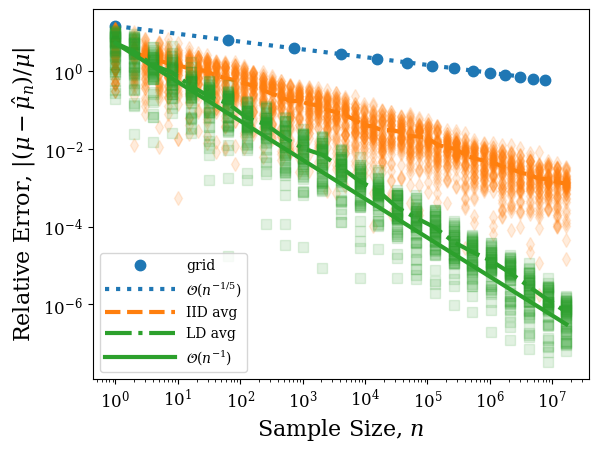

In [10]:
#Load the output for plotting
out_filename = f'Keister_d_{d}_n_max_{n_max}_n_rep_{n_rep}.pkl'
with open(figpath+out_filename,'rb') as myfile: 
    d,m_max,n_rep,n_max,n_grid,n_mc,n_qmc,err_grid,err_mc,err_qmc,err_mc_avg,err_qmc_avg = pickle.load(myfile) #load in all the data


#Plot the errors and trend lines
al = 1/np.sqrt(n_rep)
keister_plt_pts_args = {"markersize" : 5,
                   "marker" : 's',
                   "linestyle" : ''}
keister_plt_lines_args = {"linewidth" : 3,
                         "markersize" : 10}
plt.loglog(n_grid, err_grid, **blue_symbol, alpha = 1, label = "grid") 
plt.loglog([n_grid[0],n_grid[-1]],[err_grid[0],err_grid[0]*(n_grid[-1]/n_grid[0])**(-1./(d-1))], ':', **keister_plt_lines_args, color = py_blue, label = "$\mathcal{O}(n^{-1/5})$")
al_scat = 1/np.sqrt(n_rep)
plt.loglog(n_mc, err_mc, **orange_symbol, alpha = al_scat)
plt.loglog(n_mc, err_mc_avg, '--', **keister_plt_lines_args, color = py_orange, label = "IID avg") 
#plt.loglog([n_mc[0],n_mc[-1]],[err_qmc_avg[0],err_qmc_avg[0]*(n_mc[-1]/n_mc[0])**(-1./2)], '-', **keister_plt_lines_args, color = py_orange, label = "$\mathcal{O}(n^{-1/2})$")
plt.loglog(n_qmc, err_qmc, **green_symbol, alpha = al_scat) 
plt.loglog(n_qmc, err_qmc_avg, '-.', **keister_plt_lines_args, color = py_green, label = "LD avg")
plt.loglog([n_qmc[0],n_qmc[-1]],[err_qmc_avg[0],err_qmc_avg[0]*(n_mc[-1]/n_mc[0])**(-1.)], '-', **keister_plt_lines_args, color = py_green, label = "$\mathcal{O}(n^{-1})$")
plt.xlabel("Sample Size, $n$", fontsize = 16)
plt.ylabel("Relative Error, $|(\mu - \hat{\mu}_n)/\mu |$", fontsize = 16)
plt.legend(loc = "lower left", handlelength=5)
if savefigs:
    plt.savefig(figpath+f"n_is_{n_max}_d_is_{d}_n_rep_is_{n_rep}_KeisterErrors."+imgfrmt,format=imgfrmt)

## Examples of ways to spread points on a hypercube

### Evenly spaced points in one dimension $(d=1)$
In one dimension it is easy to spread points evenly

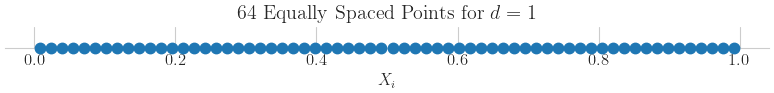

In [68]:
n = 64
xpts = np.linspace(1/(2*n), 1-1/(2*n), n) #equally spaced points between 0 and 1
fig, ax = plt.subplots()
ax.plot(xpts, np.zeros_like(xpts), **blue_symbol, zorder=10, clip_on=False) 
ax.set_ylim([0, 3e-2])
ax.set_title(f"{n:.0f} Equally Spaced Points for $d=1$")
ax.set_xlabel("$x_i$")
ax.set_aspect(1)
ax.axes.get_yaxis().set_visible(False)  #turn off the tics on the vertical axis
ax.spines[['top','right','left']].set_visible(False)  #turn off the bounding box on the top and sides
if savefigs:
    fig.savefig(figpath+f"{n:.0f}equallyspacedpts."+imgfrmt,format=imgfrmt)

### Grids in dimension $d$
Our natural thought for higher dimensions is to use rectangular grids, but as the dimension, $d$, increases, the number of different values per coordinate decreases drastically.

In [77]:
def plot_grid(xgrid, coord_to_plot = [0, 1], savefig = True, figpath = ''):
    n = xgrid.shape[0]
    d = xgrid.shape[1]
    coord_to_plot = np.minimum(coord_to_plot,[d,d]), #ensure that they are no more than d
    coord_to_plot = coord_to_plot[0]
    coord_to_plot = np.maximum(coord_to_plot,[1,1]), #ensure that they are no less than 1
    coord_to_plot = coord_to_plot[0]
    fig, ax = plt.subplots()
    ax.plot(xgrid[:,coord_to_plot[0]-1], xgrid[:,coord_to_plot[1]-1], **blue_symbol, zorder=10, clip_on=False) 
    ax.set_title(f"{n:.0f} Grid Points for $d = ${d:.0f}",fontsize=24)
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_xlabel(r'$x_{i%d}$'%(coord_to_plot[0]),fontsize=24)
    ax.set_ylabel(r'$x_{i%d}$'%(coord_to_plot[1]),fontsize=24)
    ax.set_aspect(1)
    ax.grid(False)
    if savefigs:
        fig.savefig(figpath+f"{n:.0f}gridpts_d{d:.0f}."+imgfrmt,format=imgfrmt, bbox_inches='tight')


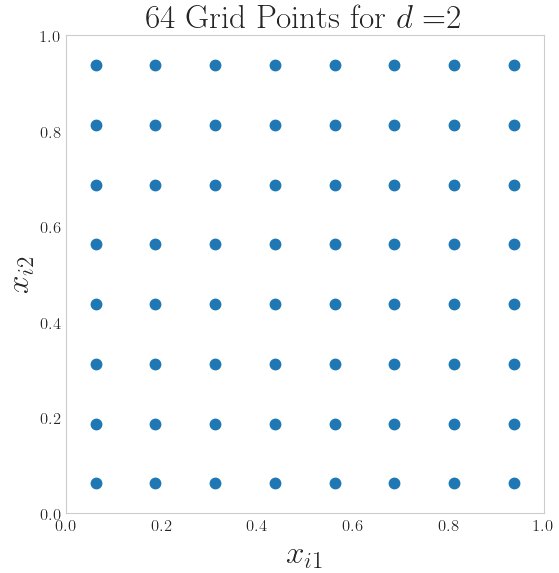

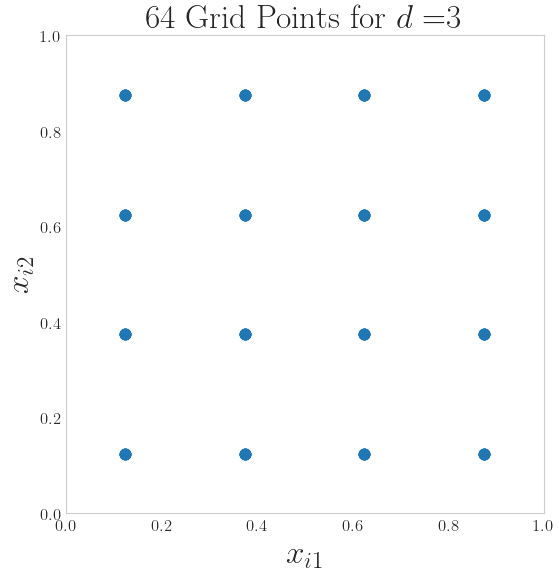

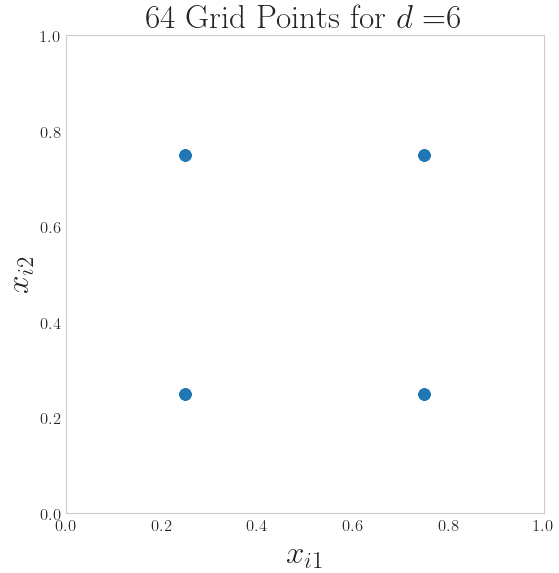

In [78]:
plot_grid(make_grid(2,8), [1,2], savefigs, figpath)
plot_grid(make_grid(3,4), [1,2], savefigs, figpath)
plot_grid(make_grid(6,2), [1,2], savefigs, figpath)

### Independent and identically distributed (IID) points
Since grids are bad, we can use IID points instead.  Note how they fill space better.

In [10]:
#Parameter values used here and below
d = 6  #the dimension used for these examples
n = 64  #the sample size used for these examples
dot_size = 15  #size of dot in some plots
line_width = 2.5

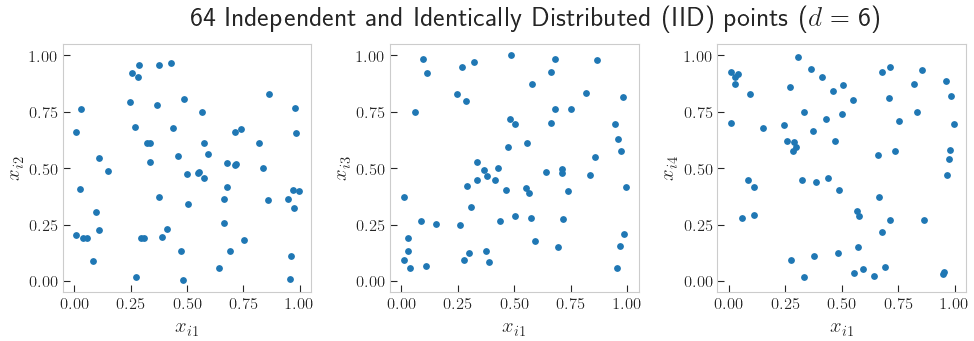

In [11]:
fig,ax = qp.plot_proj(qp.IIDStdUniform(d), n, d_horizontal = 1, d_vertical = np.arange(2,5), figfac = 10, axis_pad = 0.05, marker_size = dot_size, \
                      want_grid = False, fig_title = f"{n} Independent and Identically Distributed (IID) points ($d = $ {d})")
if savefigs:
        fig.savefig(figpath+f"{n:.0f}iidpts_d{d:.0f}."+imgfrmt,format=imgfrmt, bbox_inches='tight')

### Low disrepancy points
There are several kinds of low discrepancy points, includng Sobol', lattice, and Halton.  Below we display one kind.

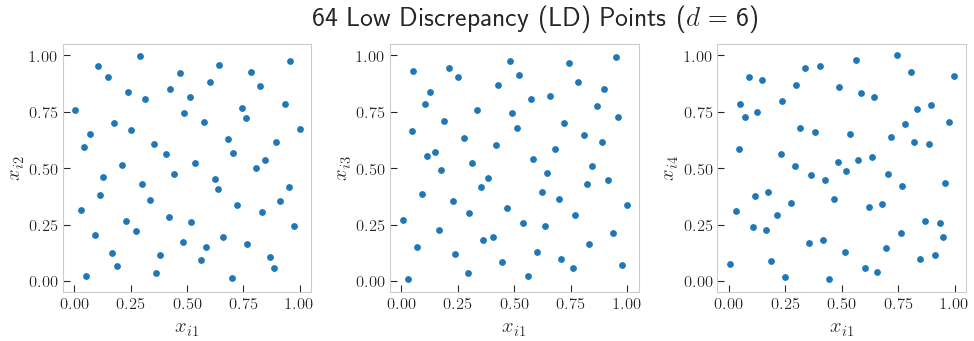

In [12]:
fig,ax = qp.plot_proj(qp.Sobol(d), n, d_horizontal = 1, d_vertical = np.arange(2,5), figfac = 10, axis_pad = 0.05, marker_size = dot_size,  \
                      want_grid = False, fig_title = f"{n} Low Discrepancy (LD) Points ($d = $ {d})")
    #d_horizontal and d_vertical are the tuples of coordinates to plot
if savefigs:
        fig.savefig(figpath+f"{n:.0f}sobolpts_d{d:.0f}."+imgfrmt,format=imgfrmt,bbox_inches='tight')

### Integration Lattices

#### Constructing an integration lattice
$$
\vx_i = i \vh / n \ \pmod{1}, \qquad i = 0, \ldots, n-1
$$

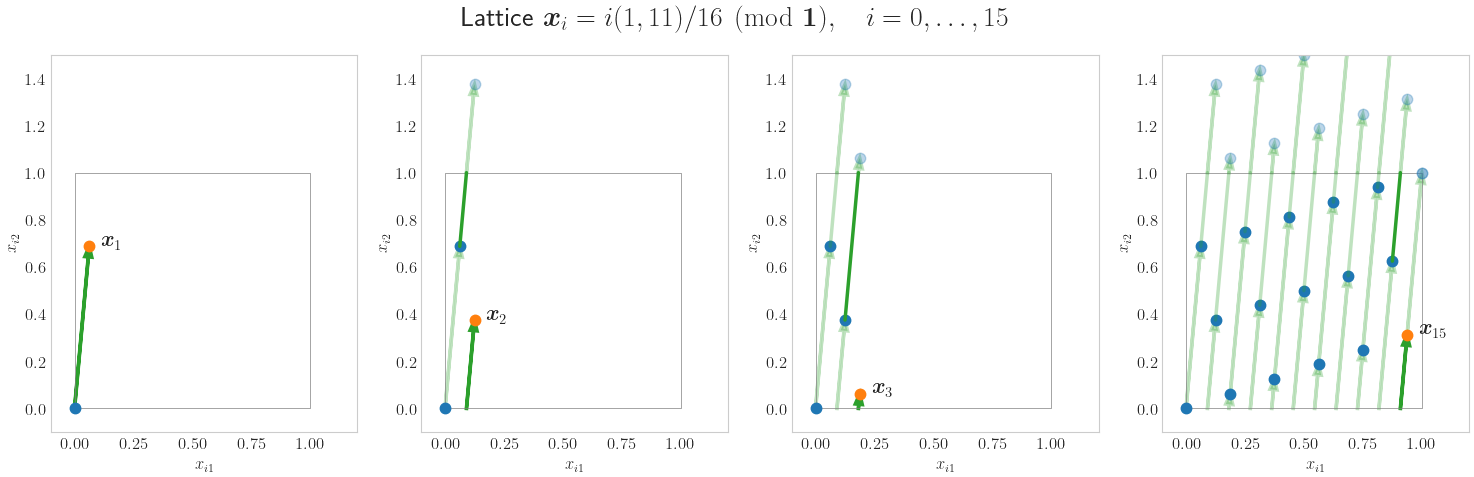

In [13]:
h_gen = np.array([1, 11])
n = 16
d = h_gen.size
x_lat = np.mod(np.arange(0,n).reshape(n,1)*h_gen.reshape(1,d)/n,1)
#x_lat = qp.Lattice(d,randomize = False).gen_samples(n)

al_fade = 0.3
x_off = 0.05
an_ft = 15
arrow_style = {"color" : py_green, "head_width" : 0.03, "length_includes_head" : True, "linewidth" : line_width}
n_plt = 4
fig, ax = plt.subplots(1,n_plt,figsize = (15,5))
for ii in range(n_plt):
    ax[ii].set_xlim([-0.1, 1.2])
    ax[ii].set_ylim([-0.1, 1.5])
    ax[ii].set_aspect(1) 
    ax[ii].grid(False)
    ax[ii].plot([0,0,1,1,0],[0,1,1,0,0], linewidth = 0.5, color = "gray")
    ax[ii].set_xlabel("$x_{i1}$")
    ax[ii].set_ylabel("$x_{i2}$")

    
ax[0].plot(x_lat[0,0],x_lat[0,1],'.',markersize = dot_size)
ax[0].plot(x_lat[1,0],x_lat[1,1],'.',markersize = dot_size)
ax[0].arrow(x_lat[0,0],x_lat[0,1],h_gen[0]/n,h_gen[1]/n,**arrow_style)
ax[0].annotate(f"$\\boldsymbol{{x}}_1$",(x_lat[1,0]+x_off,x_lat[1,1]), fontsize = an_ft)


for jj in range(1,4):  #next three plots
    over_ctr = 0  #how many times higher than one
    ax[jj].plot(x_lat[0,0],x_lat[0,1],'.',color = py_blue, markersize = dot_size) #plot the origin
    x_next_vert = x_lat[0,1]+h_gen[1]/n  #how high the next point may go
    kk = 1  #next is the first point
    cond = (over_ctr < jj)  or ((jj == 3) & (kk < n))
    #print("jj = ",jj,"kk = ",kk,"cond =",cond)
    while cond :
        while x_next_vert < 1:  #as long as the next point does not go to high
            ax[jj].plot(x_lat[kk,0],x_lat[kk,1],'.',color = py_blue, markersize = dot_size)  #plot next point
            ax[jj].arrow(x_lat[kk-1,0],x_lat[kk-1,1],h_gen[0]/n,h_gen[1]/n,alpha = al_fade,**arrow_style)  #plot arrow to nexgt point
            x_next_vert = x_lat[kk,1]+h_gen[1]/n  #how high does the next point go
            kk += 1  #increment next point
        over_ctr +=1  #this next point will go over the vertical axis
        #print("over_ctr =",over_ctr)
        cond = (over_ctr < jj)  or ((jj == 3) & (kk < n-1)) #is this the last jump or the last figure
        #print("jj = ",jj,"kk = ",kk,"n =",n,"cond =",cond)
        xcross = x_lat[kk-1,0]+(1.-x_lat[kk-1,1])*h_gen[0]/h_gen[1]  #determine the crosssing point 
        if cond:  #if not over more than allowed number of times 
            ax[jj].plot([x_lat[kk-1,0],xcross],[x_lat[kk-1,1],1],'-',color = py_green, alpha = al_fade, linewidth = line_width)  #plot the bottom part of the arrow
            ax[jj].arrow(xcross,1,x_lat[kk,0]-xcross,x_lat[kk,1],alpha = al_fade,**arrow_style)  #plot the top part of the arrow
            ax[jj].arrow(xcross,0,x_lat[kk,0]-xcross,x_lat[kk,1],alpha = al_fade,**arrow_style)  #plot the top part of the wrapped around arrow
            ax[jj].plot(x_lat[kk,0],x_lat[kk,1],'.',color = py_blue, markersize = dot_size)  #plot the new point
        else:
            #print("jj = ",jj,"kk = ",kk,"n =",n,"cond =",cond)
            ax[jj].plot([x_lat[kk-1,0],xcross],[x_lat[kk-1,1],1],'-',color = py_green,linewidth = line_width)
            ax[jj].arrow(xcross,1,x_lat[kk,0]-xcross,x_lat[kk,1],alpha = al_fade,**arrow_style)
            ax[jj].arrow(xcross,0,x_lat[kk,0]-xcross,x_lat[kk,1],**arrow_style)
            ax[jj].annotate(f"$\\boldsymbol{{x}}_{{{kk}}}$",(x_lat[kk,0]+x_off,x_lat[kk,1]), fontsize = an_ft)
            ax[jj].plot(x_lat[kk,0],x_lat[kk,1],'.',color = py_orange, markersize = dot_size)  #plot the new point
        ax[jj].plot(x_lat[kk,0],1 + x_lat[kk,1],'.',color = py_blue, markersize = dot_size, alpha = al_fade)  #plot the new point before wrap around
        x_next_vert = x_lat[kk,1]+h_gen[1]/n
        kk += 1
        cond = (over_ctr < jj)  or ((jj == 3) & (kk < n))
        #print("jj = ",jj,"kk = ",kk,"n =",n,"cond =",cond)

ax[3].plot(1.,1. , '.',markersize = dot_size, color = py_blue, alpha = al_fade)
ax[3].plot(1.,1. , '.',markersize = dot_size, color = py_blue, alpha = al_fade)
ax[3].arrow(x_lat[-1,0],x_lat[-1,1],h_gen[0]/n,h_gen[1]/n,alpha = al_fade,**arrow_style)
        
fig.text(0.5,0.95,f"Lattice $\\boldsymbol{{x}}_i = i ({h_gen[0]},{h_gen[1]})/{n} \\pmod{{\\boldsymbol{{1}}}}, \\quad i = 0, \\ldots, {n-1}$", ha = 'center', va = 'center', fontsize = 20)
if savefigs:
        fig.savefig(figpath+f"{n:.0f}_lattice_construct_d{d:.0f}."+imgfrmt,format=imgfrmt,bbox_inches='tight')

#### Constructing a __shifted__ integration lattice
$$
\vx_i = i \vh / n + \boldsymbol{\Delta} \ \pmod{1}, \qquad i = 0, \ldots, n-1
$$

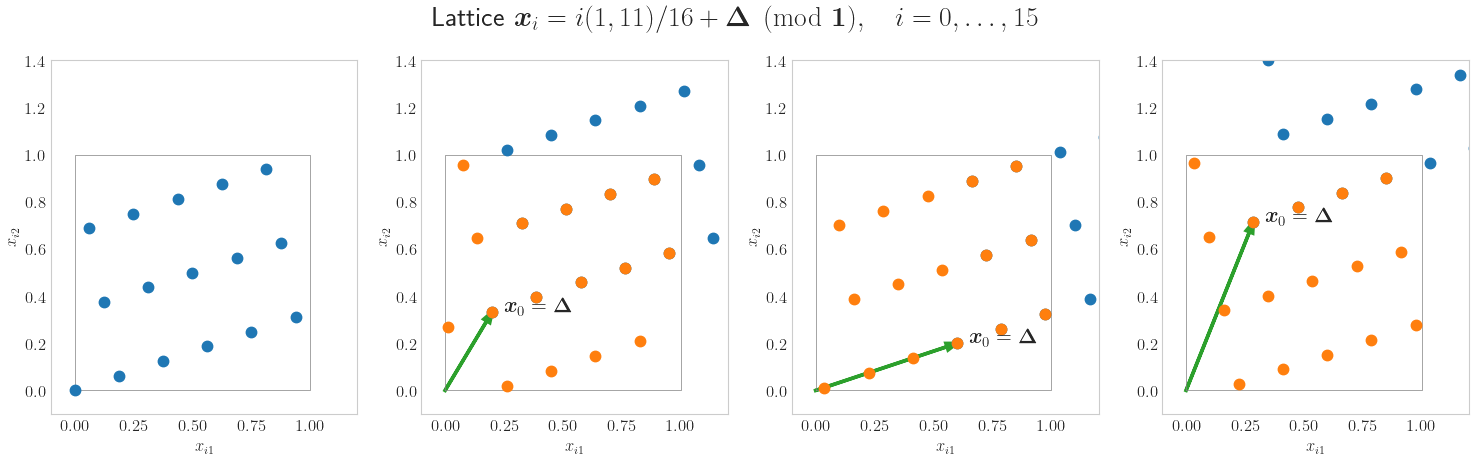

In [14]:
x_lat = x_lat[:,0:2]
n_plt = 4
fig, ax = plt.subplots(1,n_plt,figsize = (15,5))
for ii in range(n_plt):
    ax[ii].set_xlim([-0.1, 1.2])
    ax[ii].set_ylim([-0.1, 1.4])
    ax[ii].set_aspect(1) 
    ax[ii].grid(False)
    ax[ii].plot([0,0,1,1,0],[0,1,1,0,0], linewidth = 0.5, color = "gray")
    ax[ii].set_xlabel("$x_{i1}$")
    ax[ii].set_ylabel("$x_{i2}$")

shift = np.array([[1/5,1/3],[3/5,1/5],[2/7,5/7]])
    
ax[0].plot(x_lat[:,0],x_lat[:,1],'.',markersize = dot_size)

for ii in range(1,4):
    x_shlat = x_lat + shift[ii-1,:]
    x_shlatmod = np.mod(x_shlat,1)
    ax[ii].plot(x_shlat[:,0],x_shlat[:,1],'.',markersize = dot_size)
    ax[ii].plot(x_shlatmod[:,0],x_shlatmod[:,1],'.',markersize = dot_size)
    ax[ii].arrow(0,0,x_shlat[0,0],x_shlat[0,1],**arrow_style)
    ax[ii].annotate(f"$\\boldsymbol{{x}}_{{0}} = \\boldsymbol{{\\Delta}}$",(x_shlat[0,0]+x_off,x_shlat[0,1]), fontsize = an_ft)

fig.suptitle(f"Lattice $\\boldsymbol{{x}}_i = i ({h_gen[0]},{h_gen[1]})/{n} + \\boldsymbol{{\\Delta}} \\pmod{{\\boldsymbol{{1}}}}, \\quad i = 0, \\ldots, {n-1}$", \
             ha = 'center', va = 'center', fontsize = 20, y=0.90)
if savefigs:
        fig.savefig(figpath+f"{n:.0f}_shifted_lattice_construct_d{d:.0f}."+imgfrmt,format=imgfrmt,bbox_inches='tight')

#### van der Corput sequence, an extensible 1-D even sequence

/Users/fredhickernell/SoftwareRepositories/QMCSoftware/qmcpy/discrete_distribution/digital_net_b2/digital_net_b2.py:332


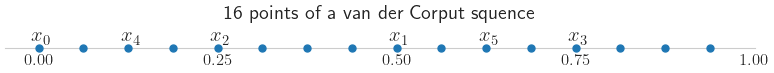

In [15]:
n = 16
xoff = -0.01
yoff = 0.01
xpts = qp.Sobol(1,randomize =  False).gen_samples(n) #equally spaced points between 0 and 1
fig, ax = plt.subplots()
ax.plot(xpts, np.zeros_like(xpts), '.', color = py_blue, markersize = 10, zorder=10, clip_on=False) 
ax.set_ylim([0, 3e-2])
ax.set_title(f"{n:.0f} points of a van der Corput squence")
#ax.set_xlabel("$x_i$")
ax.set_aspect(1)
ax.axes.get_yaxis().set_visible(False)  #turn off the tics on the vertical axis
ax.grid(False)
ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
ax.spines[['top','right','left']].set_visible(False)  #turn off the bounding box on the top and sides
for ii in range(6):
    ax.annotate(f"$x_{{{ii}}}$",(xpts[ii] + xoff, yoff), fontsize = an_ft)
if savefigs:
    fig.savefig(figpath+f"{n:.0f}vandercorputpts."+imgfrmt,format=imgfrmt)


#### Constructing an __extensible__ integration lattice
$$
\vx_i = i \vh / n \ \pmod{1}, \qquad i = 0, \ldots, n-1
$$

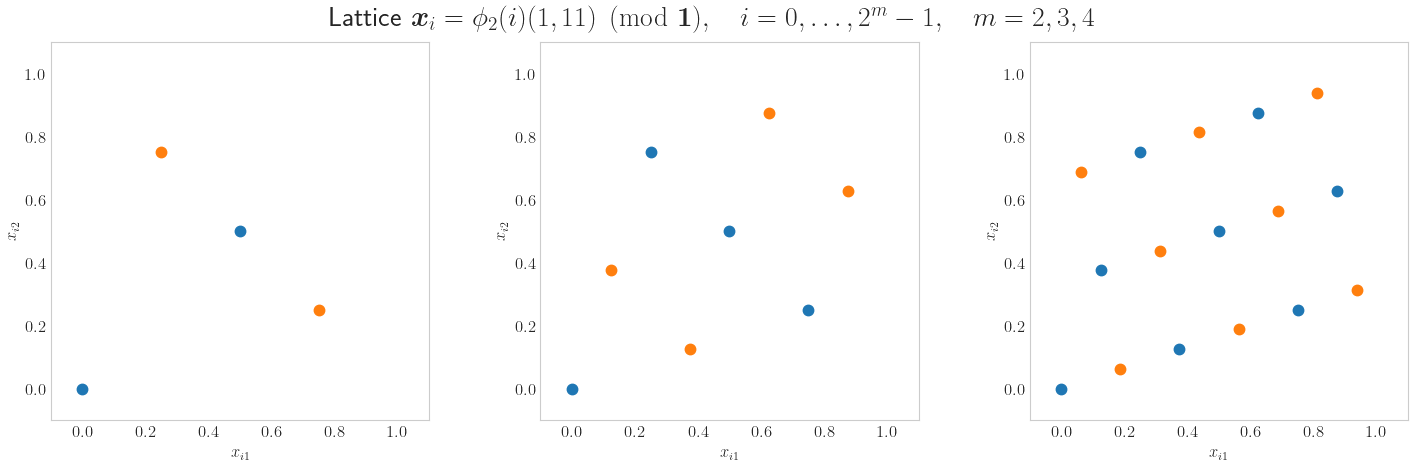

In [16]:
m = 4
n =  2**m
#h_gen = np.array([1,11])
vdc = qp.Sobol(1,randomize =  False).gen_samples(n) #equally spaced points between 0 and 1
x_lat = np.mod(vdc*h_gen,1)
#print(x_lat)
n_plt = 3
fig, ax = plt.subplots(1,n_plt,figsize = (15,5))

for ii in range(n_plt):
    jj = ii+m-n_plt
    ax[ii].set_xlim([-0.1, 1.1])
    ax[ii].set_ylim([-0.1, 1.1])
    ax[ii].set_aspect(1) 
    ax[ii].grid(False)
    ax[ii].set_xlabel("$x_{i1}$")
    ax[ii].set_ylabel("$x_{i2}$")
    nstart = 0
    ax[ii].plot(x_lat[0:2**jj,0],x_lat[0:2**jj,1],'.',color = color_cycle[0], markersize = dot_size)
    ax[ii].plot(x_lat[2**jj:2**(jj+1),0],x_lat[2**jj:2**(jj+1),1],'.',color = color_cycle[1], markersize = dot_size)

fig.suptitle(f"Lattice $\\boldsymbol{{x}}_i = \\phi_2(i) ({h_gen[0]},{h_gen[1]}) \\pmod{{\\boldsymbol{1}}}, \\quad i = 0, \\ldots, 2^m - 1, \\quad m = 2, 3, 4$", \
             ha = 'center', va = 'center', fontsize = 20, y = 0.92)
if savefigs:
        fig.savefig(figpath+f"{n:.0f}_extensible_lattice_construct_d{d:.0f}."+imgfrmt,format=imgfrmt,bbox_inches='tight')

#### Constructing an __extensible__ and __shifted__ integration lattice
$$
\vx_i = i \vh / n + \boldsymbol{\Delta} \ \pmod{1}, \qquad i = 0, \ldots, n-1
$$

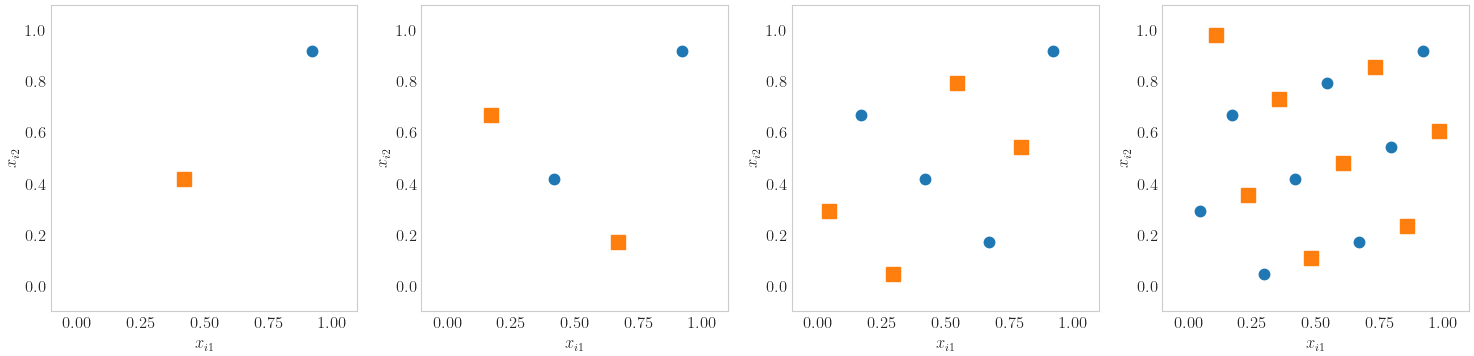

In [38]:
n =  16
x_lat = qp.Lattice(2, seed = 47).gen_samples(n)
n_plt = 4
fig, ax = plt.subplots(1,n_plt,figsize = (15,5))

for ii in range(n_plt):
    ax[ii].set_xlim([-0.1, 1.1])
    ax[ii].set_ylim([-0.1, 1.1])
    ax[ii].set_aspect(1) 
    ax[ii].grid(False)
    ax[ii].set_xlabel("$x_{i1}$")
    ax[ii].set_ylabel("$x_{i2}$")
    nstart = 0
    ax[ii].plot(x_lat[0:2**ii,0],x_lat[0:2**ii,1],'.',color = color_cycle[0], markersize = dot_size)
    ax[ii].plot(x_lat[2**ii:2**(ii+1),0],x_lat[2**ii:2**(ii+1),1],'s',color = color_cycle[1], markersize = dot_size/1.5)

#fig.text(0.55,0.95,f"Lattice $\\boldsymbol{{x}}_i = i ({h_gen[0]},{h_gen[1]})/{n} + \\boldsymbol{{\\Delta}} \\pmod{{1}}, \\quad i = 0, \\ldots, {n-1}$", ha = 'center', va = 'center', fontsize = 20)
if savefigs:
        fig.savefig(figpath+f"{n:.0f}_extensible_shifted_lattice_construct_d{d:.0f}."+imgfrmt,format=imgfrmt)

### Digital sequences

#### Digital sequences cover tiles

[[0.    0.    0.   ]
 [0.5   0.5   0.5  ]
 [0.25  0.75  0.75 ]
 [0.75  0.25  0.25 ]
 [0.125 0.625 0.375]
 [0.625 0.125 0.875]
 [0.375 0.375 0.625]
 [0.875 0.875 0.125]]
2


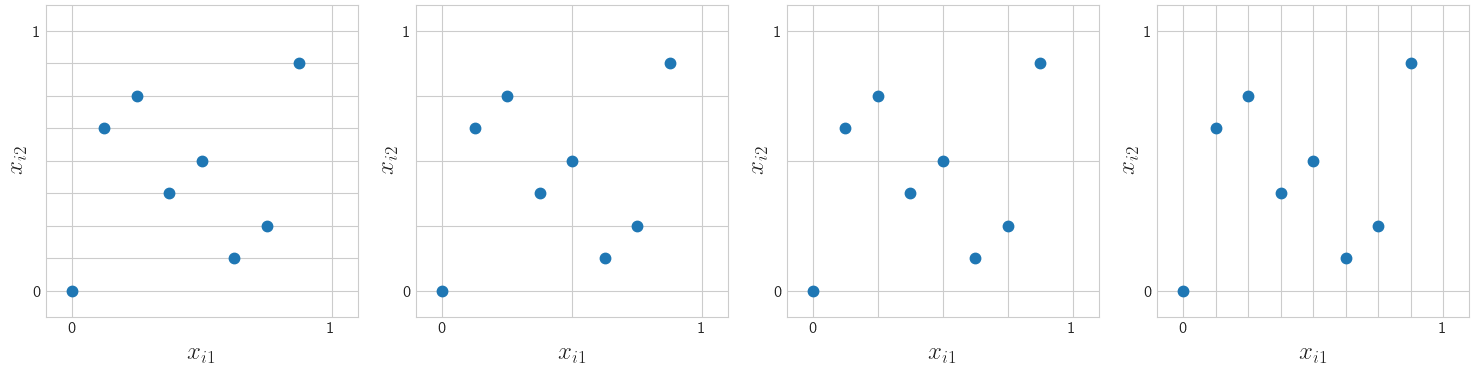

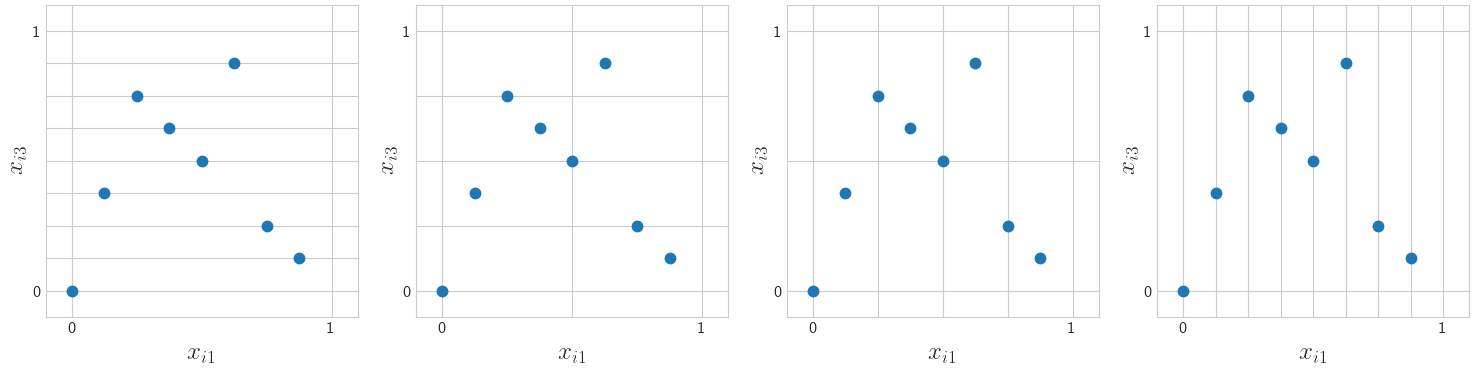

In [20]:
n_plt = 4
n = 2**(n_plt-1)
d = 3
x_sob = qp.Sobol(d, randomize = False).gen_samples(n)
print(x_sob)


coord = np.array([[0,1],[0,2]])
print(coord.shape[0])

for iii in range(coord.shape[0]):
    fig, ax = plt.subplots(1,n_plt,figsize = (15,5))
    for ii in range(n_plt):
        ax[ii].set_xlim([-0.1, 1.1])
        ax[ii].set_ylim([-0.1, 1.1])
        xticklabels = [0]
        for jj in range(2**ii-1):
            xticklabels.append("")
        xticklabels.append(1)
        ax[ii].set_xticks(np.linspace(0,1,2**ii+1),xticklabels)
        yticklabels = [0]
        for jj in range(2**(n_plt-ii-1)-1):
            yticklabels.append("")
        yticklabels.append(1)
        ax[ii].set_yticks(np.linspace(0,1,2**(n_plt-ii-1)+1),yticklabels)
        ax[ii].set_aspect(1) 
        ax[ii].set_xlabel(f"$x_{{i{coord[iii,0]+1}}}$",fontsize = 18)
        ax[ii].set_ylabel(f"$x_{{i{coord[iii,1]+1}}}$",fontsize = 18)
        #ax[ii].grid(False)
        ax[ii].plot(x_sob[:,coord[iii,0]],x_sob[:,coord[iii,1]],'.',color = color_cycle[0], markersize = dot_size)
    
    #fig.text(0.55,0.95,f"Sobol $\\boldsymbol{{x}}_i = i ({h_gen[0]},{h_gen[1]})/{n} + \\boldsymbol{{\\Delta}} \\pmod{{1}}, \\quad i = 0, \\ldots, {n-1}$", ha = 'center', va = 'center', fontsize = 20)
    if savefigs:
        fig.savefig(figpath+f"{n:.0f}_sobol_sequence_elementary_intervals_d{d:.0f}_coord_({coord[iii,0]+1},{coord[iii,1]+1})."+imgfrmt,format=imgfrmt)

#### __Randomly Shifted__ digital sequences still cover tiles

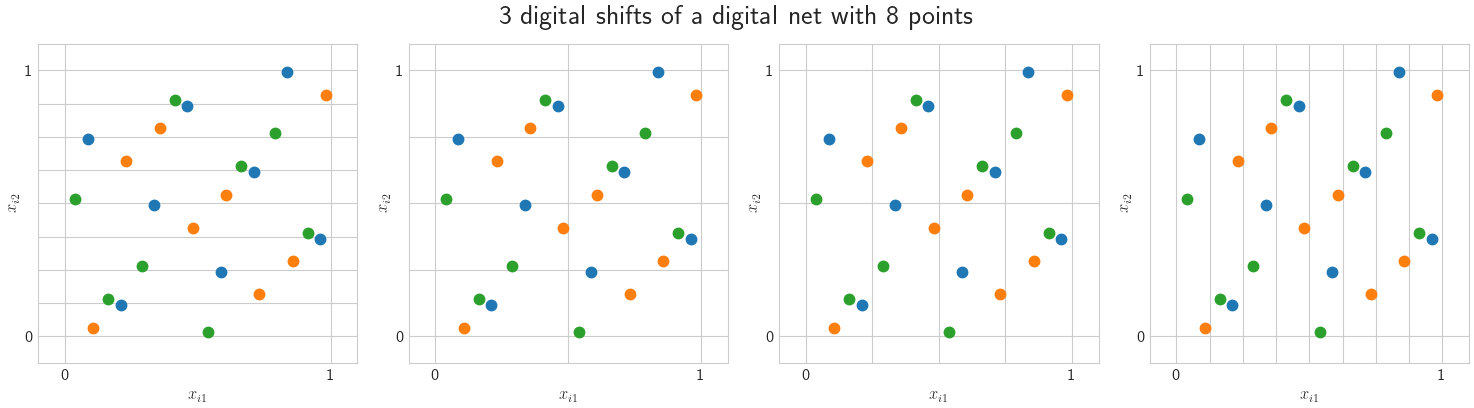

In [21]:
n_plt = 4
d = 2
n = 2**(n_plt-1)
fig, ax = plt.subplots(1,n_plt,figsize = (15,5))
n_scr = 3
for kk in range(n_scr):
    x_sob = qp.Sobol(d, randomize = "DS").gen_samples(n)  #just a digital shift applied
    for ii in range(n_plt):
        if kk == 0:
            ax[ii].set_xlim([-0.1, 1.1])
            ax[ii].set_ylim([-0.1, 1.1])
            ax[ii].set_xlabel("$x_{i1}$")
            ax[ii].set_ylabel("$x_{i2}$")
            xticklabels = [0]
            for jj in range(2**ii-1):
                xticklabels.append("")
            xticklabels.append(1)
            ax[ii].set_xticks(np.linspace(0,1,2**ii+1),xticklabels)
            yticklabels = [0]
            for jj in range(2**(n_plt-ii-1)-1):
                yticklabels.append("")
            yticklabels.append(1)
            ax[ii].set_yticks(np.linspace(0,1,2**(n_plt-ii-1)+1),yticklabels)
            ax[ii].set_aspect(1) 
            #ax[ii].grid(False)
        ax[ii].plot(x_sob[:,0],x_sob[:,1],'.',color = color_cycle[kk], markersize = dot_size)

fig.suptitle(f"{n_scr} digital shifts of a digital net with {n} points", ha = 'center', va = 'center', fontsize = 20, y=0.83)
if savefigs:
        fig.savefig(figpath+f"n_{n:}_n_sh_{n_scr}_shifted_sobol_sequence_d{d}."+imgfrmt,format=imgfrmt)

#### __Randomly Scrambled__ digital sequences still cover tiles

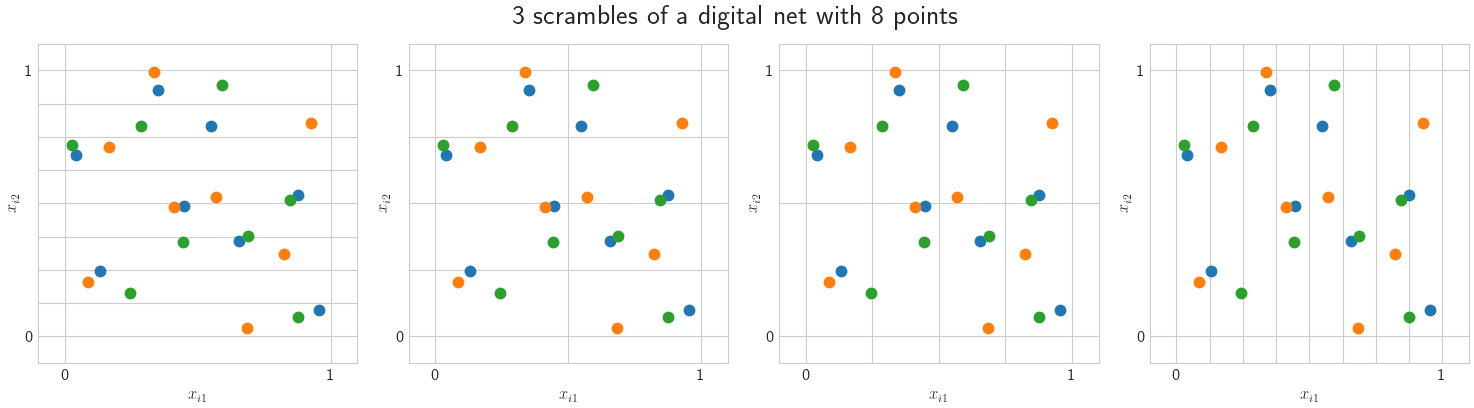

In [22]:
fig, ax = plt.subplots(1,n_plt,figsize = (15,5))
n_scr = 3
for kk in range(n_scr):
    x_sob = qp.Sobol(d).gen_samples(n)
    for ii in range(n_plt):
        if kk == 0:
            ax[ii].set_xlim([-0.1, 1.1])
            ax[ii].set_ylim([-0.1, 1.1])
            ax[ii].set_xlabel("$x_{i1}$")
            ax[ii].set_ylabel("$x_{i2}$")
            xticklabels = [0]
            for jj in range(2**ii-1):
                xticklabels.append("")
            xticklabels.append(1)
            ax[ii].set_xticks(np.linspace(0,1,2**ii+1),xticklabels)
            yticklabels = [0]
            for jj in range(2**(n_plt-ii-1)-1):
                yticklabels.append("")
            yticklabels.append(1)
            ax[ii].set_yticks(np.linspace(0,1,2**(n_plt-ii-1)+1),yticklabels)
            ax[ii].set_aspect(1) 
            #ax[ii].grid(False)
        ax[ii].plot(x_sob[:,0],x_sob[:,1],'.',color = color_cycle[kk], markersize = dot_size)

fig.suptitle(f"{n_scr} scrambles of a digital net with {n} points", ha = 'center', va = 'center', fontsize = 20, y = 0.83)
if savefigs:
        fig.savefig(figpath+f"n_{n:}_n_scr_{n_scr}_scrambled_sobol_sequence_d{d}."+imgfrmt,format=imgfrmt)

#### Digital nets are extensbile

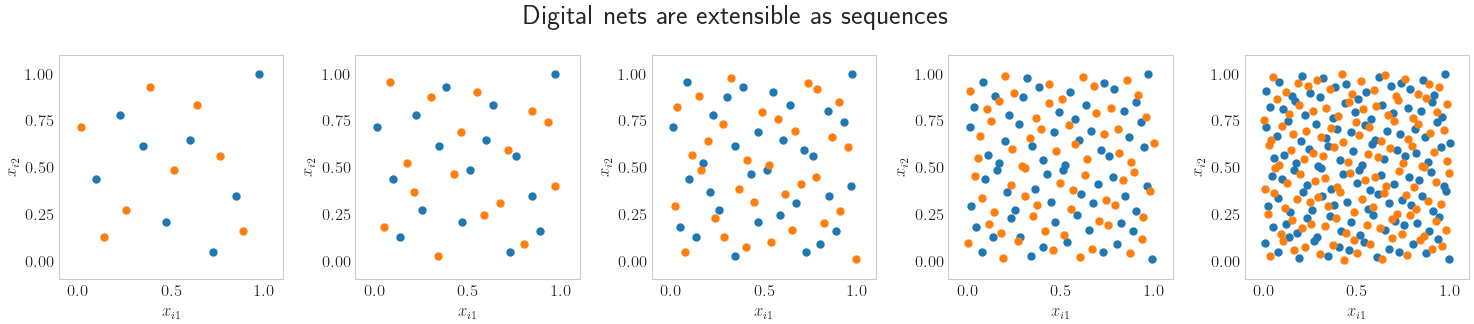

In [23]:
d = 2
n_list = np.array([8, 16, 32, 64, 128, 256])
n_plt = len(n_list)-1
x_sob = qp.Sobol(2, seed = 29).gen_samples(n_list[-1])
               
fig, ax = plt.subplots(1,n_plt,figsize = (15,5))
n_scr = 3
for ii, nn in enumerate(n_list[:n_plt]):
    ax[ii].set_xlim([-0.1, 1.1])
    ax[ii].set_ylim([-0.1, 1.1])
    ax[ii].plot(x_sob[:n_list[ii],0],x_sob[:n_list[ii],1], '.', ms = 10)
    ax[ii].plot(x_sob[n_list[ii]:n_list[ii+1],0],x_sob[n_list[ii]:n_list[ii+1],1], '.', ms = 10)
    ax[ii].set_aspect(1) 
    ax[ii].grid(False)
    ax[ii].set_xlabel("$x_{i1}$")
    ax[ii].set_ylabel("$x_{i2}$")


fig.text(0.5,0.8,f"Digital nets are extensible as sequences", ha = 'center', va = 'center', fontsize = 20)
if savefigs:
        fig.savefig(figpath+f"extensible_scrambled_sobol_sequence_d{d:.0f}."+imgfrmt,format=imgfrmt)

### Halton sequences

/Users/fredhickernell/SoftwareRepositories/QMCSoftware/qmcpy/discrete_distribution/halton.py:270


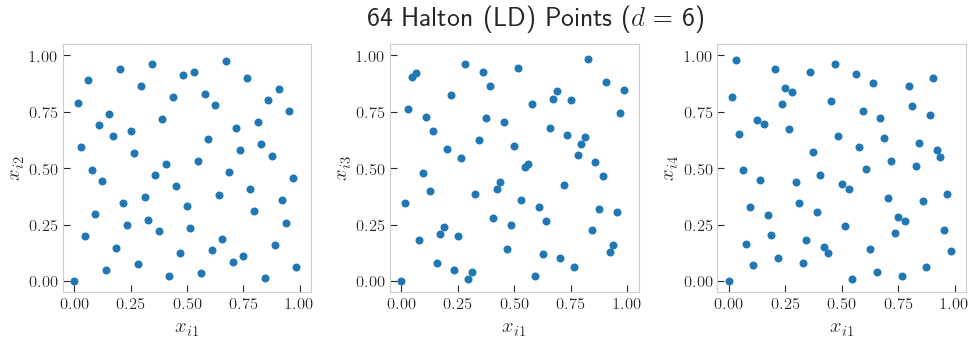

In [24]:
n = 64
d = 6
fig,ax = qp.plot_proj(qp.Halton(d, randomize = False), n, d_horizontal = 1, d_vertical = np.arange(2,5), figfac = 10, marker_size = dot_size * 1.5, axis_pad = 0.05, \
                      want_grid = False, fig_title = f"{n} Halton (LD) Points ($d = $ {d})")
    #d_horizontal and d_vertical are the tuples of coordinates to plot
if savefigs:
        fig.savefig(figpath+f"{n:.0f}Halton_pts_d{d:.0f}."+imgfrmt,format=imgfrmt,bbox_inches='tight')

## Discrepancy

### Plot kernel

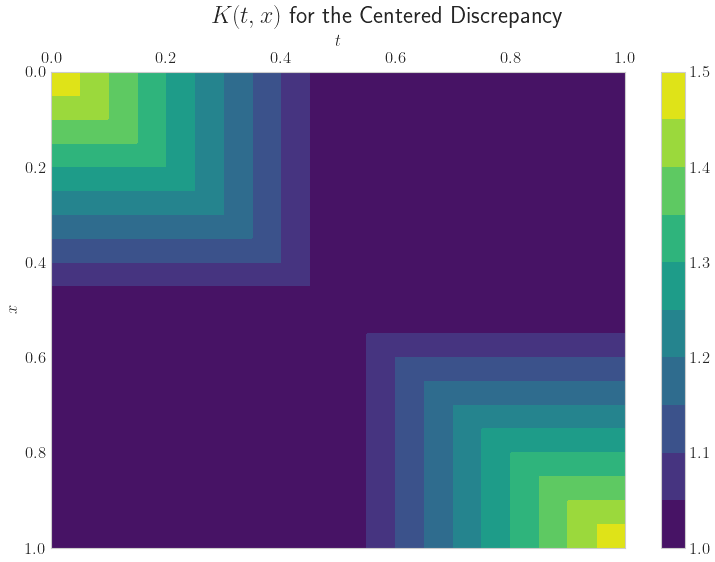

In [25]:
gram_fun = lambda x, y, weights : (1 + (0.5*weights)*(abs(x - .5) + abs(y - .5) - abs(x - y))).prod(axis=2)
n = 500
x = np.linspace(0,1,n)
y = np.linspace(0,1,n)
xmesh,ymesh = np.meshgrid(x,y)
kernel_val = gram_fun(x.reshape(n,1,1),y.reshape(1,n,1),1)
fig, ax = plt.subplots()
kernel_contour = ax.contourf(xmesh,ymesh,kernel_val,cmap = 'viridis', vmin=1, vmax=1.5, levels = 10);
ax.set_xlabel("$t$")
ax.set_ylabel("$x$")
ax.invert_yaxis(); ax.xaxis.set_label_position('top');  ax.xaxis.tick_top()
fig.suptitle("$K(t,x)$ for the Centered Discrepancy", y=0.95)
cbar = plt.colorbar(kernel_contour)

if savefigs:
        fig.savefig(figpath+f"centered_discrepancy_kernel."+imgfrmt,format=imgfrmt)

### Compute the discrepancy

#### Function to compute the discrepancy

In [26]:
def discrep(x, weights = 1, disc_kind = "C", domain = np.array([0,1]), measure_time = False, mem_limit = 2**25, IID_Flag = False):
    '''
        x = n x d numpy array of points that you want to evaluate the discrepancy of
        weighs = coordinate weights
        disc_kind = flavor of discrepancy, default is centered
        domain = domain on which the discrepancy is defined
        mem_limit = number of floating point numbers that can be easily handled in memory to avoid for loops
        IID_Flag = True if you want to compute the root mean squared discrepancy of IID points
    '''
    
    if measure_time:
        start_time = time.time()
    if x.ndim == 1:  #ensure that x is a two dimensional array, get n and d
        x = x.reshape(x.size,1)
        d = 1
        n = x.size
    else:
        n, d = x.shape

    #print("n =", n, "d = ", d)
    
    weights = np.array(weights).reshape(-1)  #turn the weights into a one-dimensional array
    if len(weights) >= d:  #use the first d weights
        weights = weights[:d]
    else:  #or just propagate the first one
        weights = weights[0] * np.ones(d)

    if disc_kind.lower().startswith("c"):
        dbl_integ_fun = lambda weights : (1 + (weights/12)).prod()
        sngl_integ_fun = lambda x, weights : (1 + (0.5*weights)*(abs(x - .5)*(1 - abs(x -.5)))).prod(axis=1)
        gram_fun = lambda x, y, weights : (1 + (0.5*weights)*(abs(x - .5) + abs(y - .5) - abs(x - y))).prod(axis=2)
        diag_integ_fun = lambda weights : (1 + (weights/4)).prod()
 
    if IID_Flag:  #root mean square discrepancy of IID points
        out = np.sqrt((diag_integ_fun(weights) - dbl_integ_fun(weights))/n)
    else:  #discrepancy of actual points input
        #compute the double integral
        dbl_integ = dbl_integ_fun(weights)

        #compute the sum of the single integral and the double sum
        sngl_integ_sum = 0
        dbl_sum = 0
        if x[0,0] != None:  #the discrepancy of some points
            len_chunk = np.floor(np.sqrt(mem_limit/d)).astype('int')
            n_chunk = np.ceil(n/len_chunk).astype('int')
            for ii in range(n_chunk):
                n_ii_start = ii*len_chunk
                n_ii_end = np.array([n,(ii+1)*len_chunk]).min()
                n_ii_batch = n_ii_end - n_ii_start
                if n_ii_batch > 0:
                    x_chunk = x[n_ii_start:n_ii_end,:]
                    sngl_integ_sum  += sngl_integ_fun(x_chunk,weights).sum(axis = 0)
                    x_chunk = x_chunk.reshape(n_ii_batch,1,d)
                    y_chunk = x_chunk.reshape(1,n_ii_batch,d)
                    dbl_sum += gram_fun(x_chunk,y_chunk,weights).sum()
                    for jj in range(ii+1,n_chunk):
                        n_jj_start = jj*len_chunk
                        n_jj_end = np.array([n,(jj+1)*len_chunk]).min()
                        n_jj_batch = n_jj_end - n_jj_start
                        if n_jj_batch > 0:
                            y_chunk = x[n_jj_start:n_jj_end,:].reshape(1,n_jj_batch,d)
                            dbl_sum += 2*gram_fun(x_chunk,y_chunk,weights).sum()
            sngl_integ_sum  *= (2/n)
            dbl_sum *= (1/(n**2)) 
        # print(dbl_integ,sngl_integ_sum,dbl_sum)
        out = np.sqrt(dbl_integ -  sngl_integ_sum + dbl_sum)

    if measure_time:  #if we are measuring time
        total_time = time.time() - start_time
        out = [out, total_time]
    return out

In [54]:
# Comparing Claude's and Fred's discrepancy functions for accuracy and compute time
n = 2**14  #number of points
d = 20  #dimension
mem_size = 2**12
xpts = qp.Sobol(d, seed = 29).gen_samples(n)
discClaude, timeClaude = qp.discrepancy2(xpts, "c",limiter = mem_size,Time = True)
discFred, timeFred = discrep(xpts,mem_limit = mem_size,measure_time = True)
print("discrepancy[Claude,Fred] =",discClaude,discFred,"time[Claude,Fred] =", timeClaude, timeFred)

discrepancy[Claude,Fred] = 0.042447938490967715 0.042447938490967715 time[Claude,Fred] = 14.36168885231018 14.471787214279175


#### Discrepancy experiment

In [77]:
n_vec = 2**np.arange(14)
d_vec = [1, 2, 3, 4, 8, 16, 64]
n_max = np.max(n_vec)
d_max = np.max(d_vec)
xpts = qp.Sobol(d_max, seed = 29).gen_samples(n_max)
x_null = np.array([[None for ii in range(d_max)]])
un_disc = np.zeros((len(n_vec),len(d_vec)))
wt_disc = np.zeros((len(n_vec),len(d_vec)))
iid_un_disc = np.zeros((len(n_vec),len(d_vec)))
iid_wt_disc = np.zeros((len(n_vec),len(d_vec)))
wts = (np.arange(d_max)+1.)**-2.
null_un_disc = np.zeros(len(d_vec))
null_wt_disc = np.zeros(len(d_vec))
for ii, d in enumerate(d_vec):
    null_un_disc[ii] = discrep(x_null[:,:d], 1, 'centered')
    null_wt_disc[ii] = discrep(x_null[:,:d], wts, 'centered')
    for jj, n in enumerate(n_vec):
        if (jj == 0) or (n == n_max):
            print("Starting d =",d,", n=",n)
        un_disc[jj,ii] = discrep(xpts[:n,:d],1, 'centered')
        wt_disc[jj,ii] = discrep(xpts[:n,:d], wts, 'centered')
        iid_un_disc[jj,ii] = discrep(xpts[:n,:d], 1, 'centered', IID_Flag = True)
        iid_wt_disc[jj,ii] = discrep(xpts[:n,:d], wts, 'centered', IID_Flag = True)

out_filename = f'CtrDisc_dmax_{d_max}_nmax_{n_max}.pkl'
stored_vars  = [un_disc,wt_disc,iid_un_disc,iid_wt_disc,null_un_disc,null_wt_disc,d_vec,n_vec]
with open(figpath+out_filename,'wb') as myfile: 
    pickle.dump(stored_vars,myfile)  #save numerical output as a pickle file
print("Finished")

Starting d = 1 , n= 1
Starting d = 1 , n= 8192
Starting d = 2 , n= 1
Starting d = 2 , n= 8192
Starting d = 3 , n= 1
Starting d = 3 , n= 8192
Starting d = 4 , n= 1
Starting d = 4 , n= 8192
Starting d = 8 , n= 1
Starting d = 8 , n= 8192
Starting d = 16 , n= 1
Starting d = 16 , n= 8192
Starting d = 64 , n= 1
Starting d = 64 , n= 8192
Finished


### Plot discrepancy

#### Input data for plotting

In [27]:
n_max = 2**13
d_max = 64
out_filename = f'CtrDisc_dmax_{d_max}_nmax_{n_max}.pkl'
with open(figpath+out_filename,'rb') as myfile: 
    un_disc,wt_disc,iid_un_disc,iid_wt_disc,null_un_disc,null_wt_disc,d_vec,n_vec = pickle.load(myfile) #load in all the data

#### Draw the plots

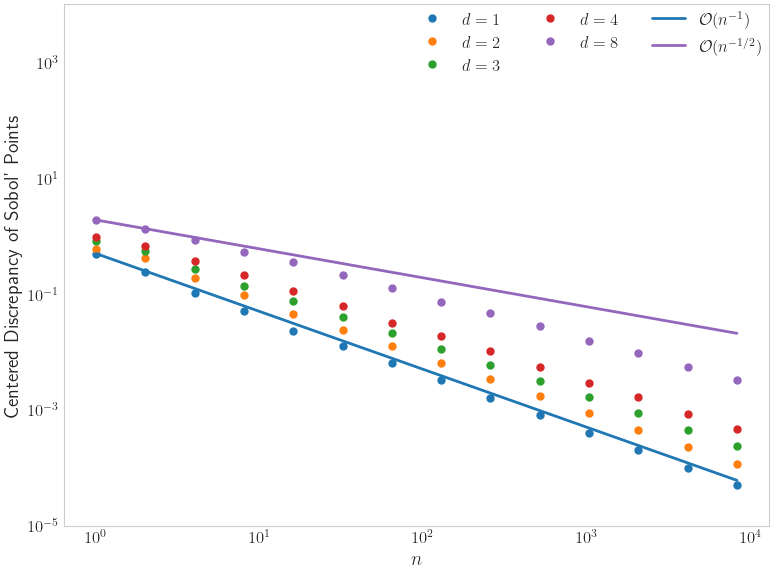

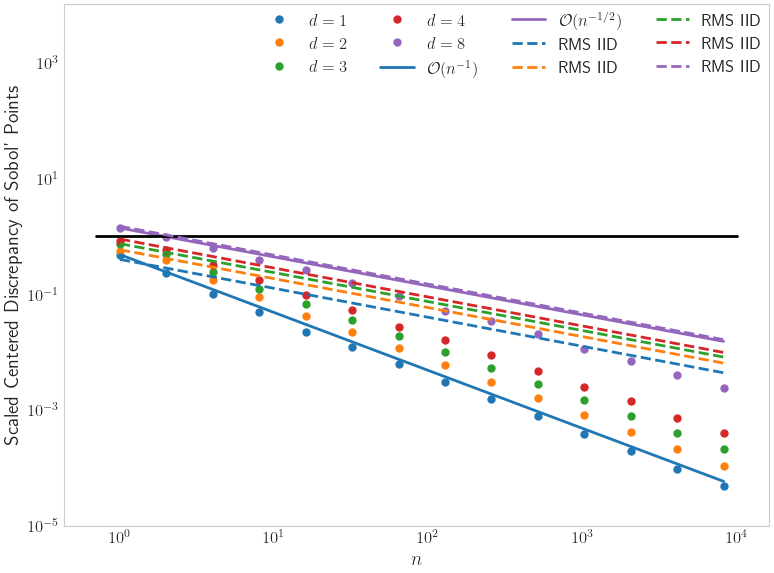

Finished Plot 0


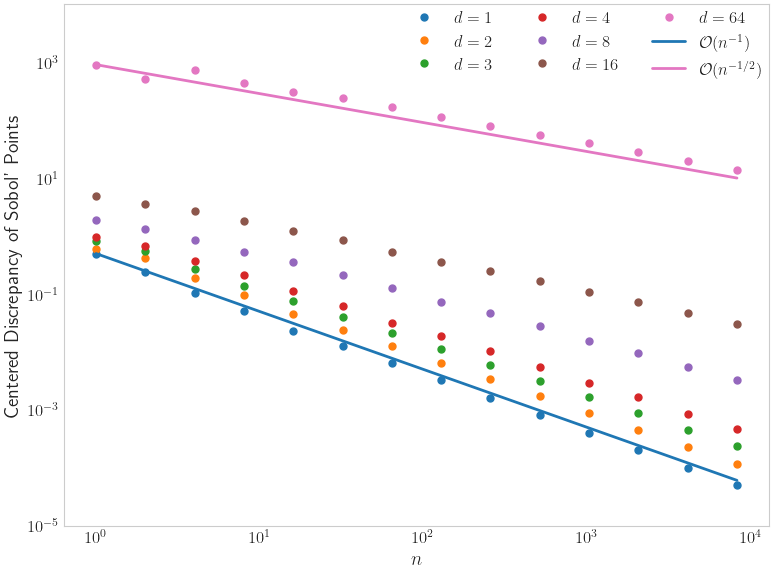

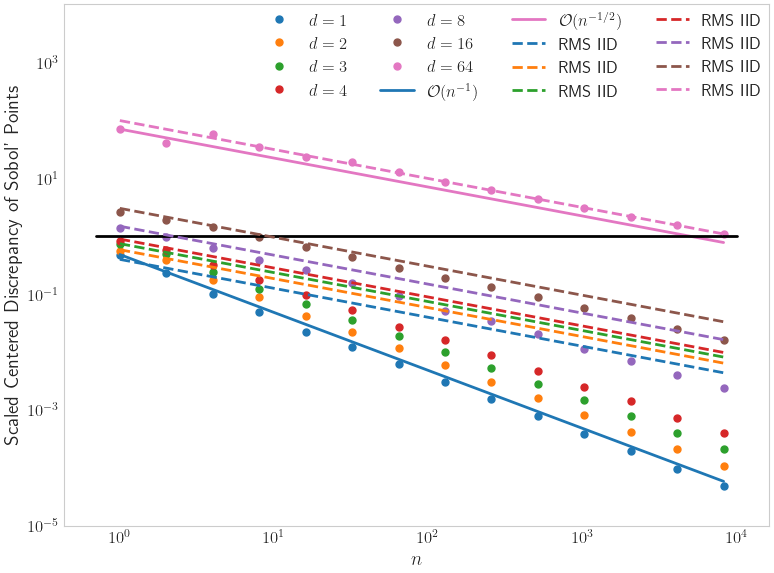

Finished Plot 1


In [28]:
sc_un_disc = un_disc/null_un_disc
sc_iid_un_disc = iid_un_disc/null_un_disc

which_dim=[[0, 1, 2, 3, 4], range(len(d_vec))]
for iii, d_list in enumerate(which_dim):
    d_last = d_vec[d_list[-1]]

    #plot raw discrepancy
    fig, ax = plt.subplots()
    for ii, wh_d in enumerate(d_list):
        d = d_vec[wh_d]
        ax.loglog(n_vec,un_disc[:,wh_d],'.', markersize = 10, label = f"$d = {{{d}}}$")
    ax.loglog(n_vec[[0,-1]], un_disc[0,0]*np.array([1., n_vec[0]/n_vec[-1]]),'-', color = py_blue, label = f"$\\mathcal{{O}}(n^{{-1}})$")
    ax.loglog(n_vec[[0,-1]], un_disc[0,d_list[-1]]*np.array([1., np.sqrt(n_vec[0]/n_vec[-1])]),'-', color = color_cycle[d_list[-1]], label = f"$\\mathcal{{O}}(n^{{-1/2}})$")
    ax.set_xlabel(f"${{n}}$",fontsize=14)
    ax.set_ylabel(f"Centered Discrepancy of Sobol' Points",fontsize=14)
    ax.set_ylim([1e-5,1e4])
    ax.legend(loc='upper right', ncol = 3, frameon = False)
    ax.grid(False)
    plt.subplots_adjust(top=0.95,right = 0.95)
    if savefigs:
            fig.savefig(figpath+f"SobolCtrDisc_n_{n_max}_d{d_last}."+imgfrmt,format=imgfrmt)
    
    #plot scaled discrepancy
    fig, ax = plt.subplots()
    for ii, wh_d in enumerate(d_list):
        d = d_vec[wh_d]
        ax.loglog(n_vec,sc_un_disc[:,wh_d],'.', markersize = 10, label = f"$d = {{{d}}}$")
    ax.loglog(n_vec[[0,-1]], sc_un_disc[0,0]*np.array([1., n_vec[0]/n_vec[-1]]),'-', color = py_blue, label = f"$\\mathcal{{O}}(n^{{-1}})$")
    ax.loglog(n_vec[[0,-1]], sc_un_disc[0,d_list[-1]]*np.array([1., np.sqrt(n_vec[0]/n_vec[-1])]),'-', color = color_cycle[d_list[-1]], label = f"$\\mathcal{{O}}(n^{{-1/2}})$")
    ax.loglog([0.7,1e4], [1.,1], '-', color = 'black')
    ax.set_xlabel(f"${{n}}$",fontsize=14)
    ax.set_ylabel(f"Scaled Centered Discrepancy of Sobol' Points",fontsize=14)
    ax.set_ylim([1e-5,1e4])
    ax.grid(False)
    ax.legend(loc='upper right', ncol = 4, frameon = False)
    plt.subplots_adjust(top=0.95,right = 0.95)
    
    if savefigs:
            fig.savefig(figpath+f"SobolScaledCtrDisc_n_{n_max}_d{d_last}."+imgfrmt,format=imgfrmt)
    
    for ii, wh_d in enumerate(d_list):  #Add IID scaled discrepancy
        ax.loglog(n_vec[[0,-1]], sc_iid_un_disc[0,wh_d]*np.array([1., np.sqrt(n_vec[0]/n_vec[-1])]),'--', color = color_cycle[wh_d], label = f"RMS IID")
    ax.grid(False)
    ax.legend(loc='upper right', ncol = 4, frameon = False)
    
    plt.show()
    if savefigs:
            fig.savefig(figpath+f"IIDSobolScaledCtrDisc_n_{n_max}_d{d_last}."+imgfrmt,format=imgfrmt)
    print("Finished Plot",iii)


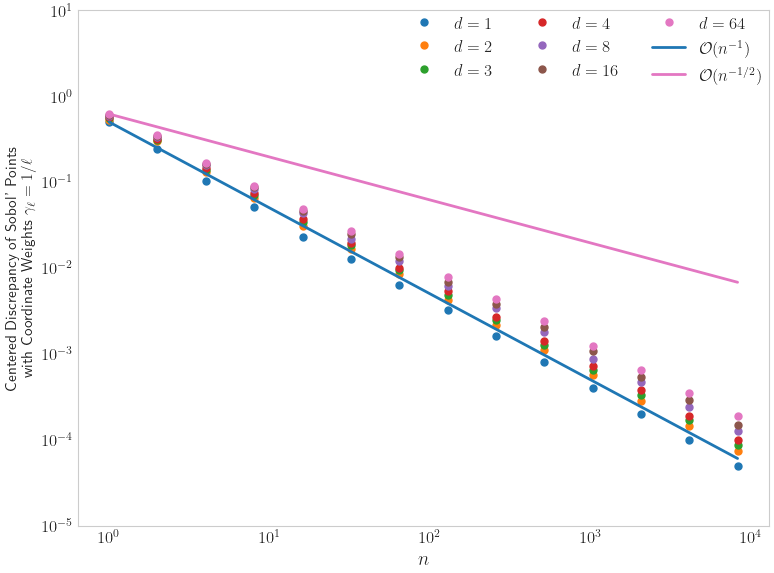

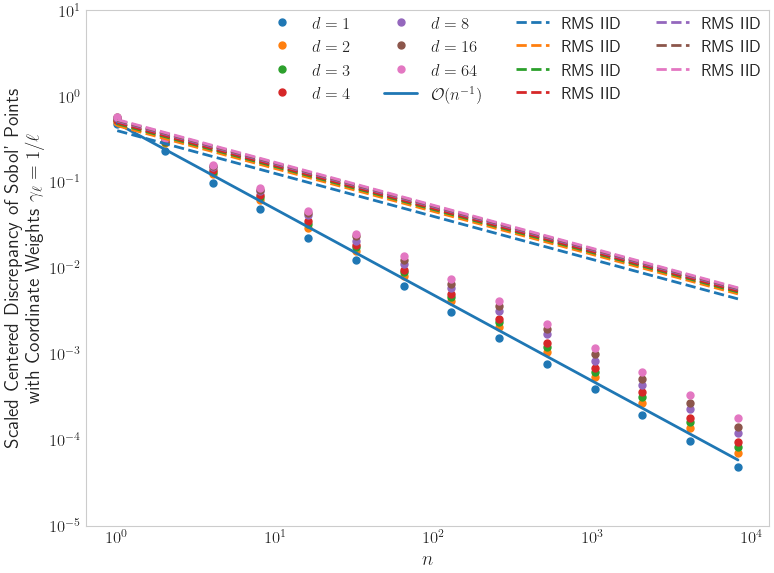

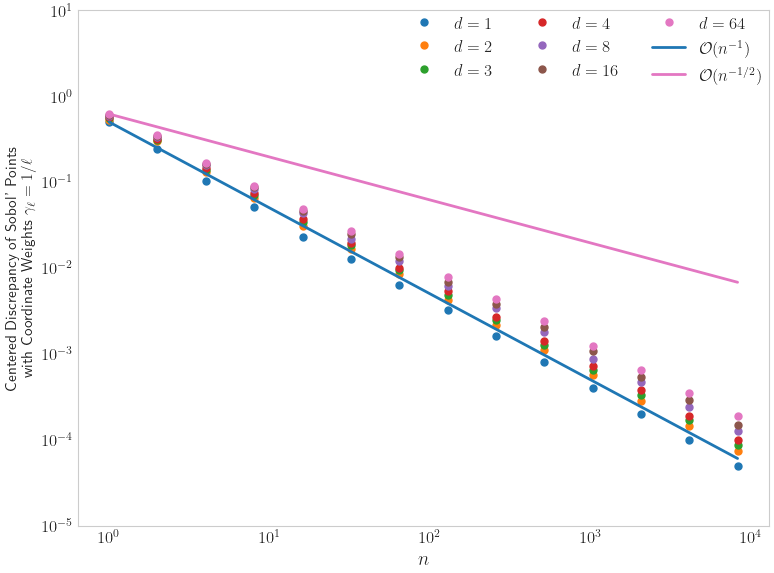

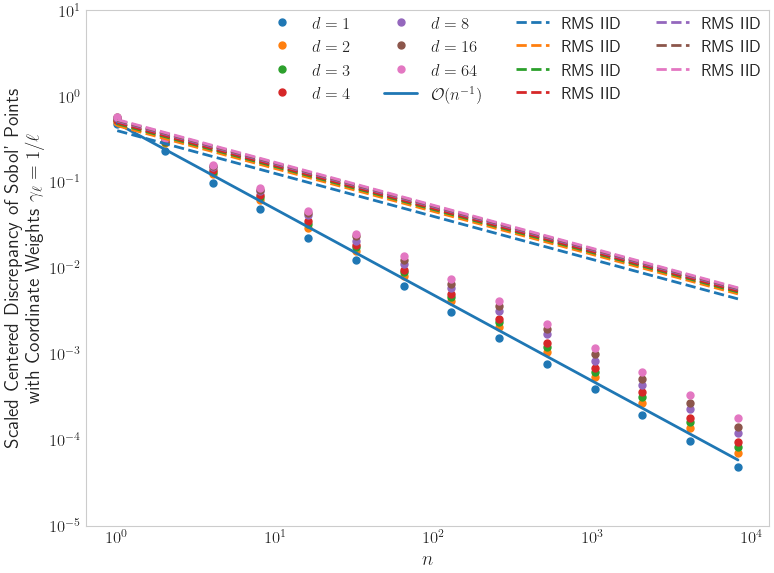

In [29]:
which_dim=[[0, 1, 2, 3, 4], range(len(d_vec))]
sc_wt_disc = wt_disc/null_wt_disc
sc_iid_wt_disc = iid_wt_disc/null_wt_disc

for iii, d_list in enumerate(which_dim):
    d_last = d_vec[d_list[-1]]
    
    #plot raw weighted discrepancy
    fig, ax = plt.subplots()
    for ii, d in enumerate(d_vec):
        ax.loglog(n_vec,wt_disc[:,ii],'.', markersize = 10, label = f"$d = {{{d}}}$")
    ax.loglog(n_vec[[0,-1]], wt_disc[0,0]*np.array([1., n_vec[0]/n_vec[-1]]),'-', color = py_blue, label = f"$\\mathcal{{O}}(n^{{-1}})$")
    ax.loglog(n_vec[[0,-1]], wt_disc[0,-1]*np.array([1., np.sqrt(n_vec[0]/n_vec[-1])]),'-', color = color_cycle[ii], label = f"$\\mathcal{{O}}(n^{{-1/2}})$")
    ax.set_xlabel(f"${{n}}$",fontsize=14)
    ax.set_ylabel(f"Centered Discrepancy of Sobol' Points \n with Coordinate Weights $\gamma_\ell = 1/\ell$",fontsize=11)
    ax.set_ylim([1e-5,1e1])
    ax.legend(loc='upper right', ncol = 3, frameon = False)
    ax.grid(False)
    plt.subplots_adjust(top=0.95, right=0.95, left = 0.15)
    if savefigs:
            fig.savefig(figpath+f"SobolWtCtrDisc_n_{n_max}_d{d_max}."+imgfrmt,format=imgfrmt)

    #plot scaled discrepancy
    fig, ax = plt.subplots()
    for ii, d in enumerate(d_vec):
        ax.loglog(n_vec,sc_wt_disc[:,ii],'.', markersize = 10, label = f"$d = {{{d}}}$")
    ax.loglog(n_vec[[0,-1]], sc_wt_disc[0,0]*np.array([1., n_vec[0]/n_vec[-1]]),'-', color = py_blue, label = f"$\\mathcal{{O}}(n^{{-1}})$")
    #ax.loglog(n_vec[[0,-1]], sc_wt_disc[0,-1]*np.array([1., np.sqrt(n_vec[0]/n_vec[-1])]),'-', color = color_cycle[ii], label = f"$\\mathcal{{O}}(n^{{-1/2}})$")
    #ax.loglog([0.7,1e4], [1.,1], '-', color = 'black')
    ax.set_xlabel(f"${{n}}$",fontsize=14)
    ax.set_ylabel(f"Scaled Centered Discrepancy of Sobol' Points \n with Coordinate Weights $\gamma_\ell = 1/\ell$",fontsize=14)
    ax.set_ylim([1e-5,1e1])
    ax.grid(False)
    ax.legend(loc='upper right', ncol = 4, frameon = False)
    plt.subplots_adjust(top=0.95, right=0.95, left = 0.15)
    
    if savefigs:
            fig.savefig(figpath+f"SobolScaledWtCtrDisc_n_{n_max}_d{d_max}."+imgfrmt,format=imgfrmt)
    
    for ii, d in enumerate(d_vec):  #Add IID scaled discrepancy
        ax.loglog(n_vec[[0,-1]], sc_iid_wt_disc[0,ii]*np.array([1., np.sqrt(n_vec[0]/n_vec[-1])]),'--', color = color_cycle[ii], label = f"RMS IID")
    ax.grid(False)
    ax.legend(loc='upper right', ncol = 4, frameon = False)
    
    plt.show()
    if savefigs:
            fig.savefig(figpath+f"IIDSobolScaledWtCtrDisc_n_{n_max}_d{d_max}."+imgfrmt,format=imgfrmt)



### Pathological example

In [48]:
patho = lambda x : np.prod(x-1/2, axis = 1)
d = 10
n = 1024
xIID = qp.IIDStdUniform(d).gen_samples(n)
xNet = qp.DigitalNetB2(d).gen_samples(n)
y = patho(xIID)
muhatIID = np.mean(y)
print(muhatIID)
print(patho(xNet).mean())

3.297011154821619e-08
-4.674130482036641e-08


## Variable Transformations

### Asian Option Example

#### Set up option paramters

In [18]:
option_param = {"call_put" : 'call',
                "start_price" : 100, 
                "strike_price" : 125,
                "volatility" : .45,
                "interest_rate" : .05,
                "t_final" : 1
               }
d = 52 
tol_list = np.array([0.1, 0.05, 0.02, 0.01, 0.005, 0.002, 0.001])

#### Compute option price for different error tolerances and record execution times

In [19]:
asian_call_PCA_IID = qp.AsianOption(qp.IIDStdUniform(d), decomp_type = 'PCA', **option_param)
exec_time_PCA_IID = np.zeros_like(tol_list)
n_PCA_IID = np.zeros_like(tol_list)
asian_call_PCA = qp.AsianOption(qp.DigitalNetB2(d), decomp_type = 'PCA', **option_param)
exec_time_PCA = np.zeros_like(tol_list)
n_PCA = np.zeros_like(tol_list)
asian_call_Chol = qp.AsianOption(qp.DigitalNetB2(d),decomp_type = 'Cholesky', **option_param)
exec_time_Chol = np.zeros_like(tol_list)
n_Chol = np.zeros_like(tol_list)
for ii, tol in enumerate(tol_list):
    print("abs_tol =",tol)
    if tol >= 0.01:
        price_PCA_IID, data_PCA_IID = qp.CubMCG(asian_call_PCA_IID, abs_tol = tol).integrate()
        exec_time_PCA_IID[ii] = data_PCA_IID.time_integrate
        n_PCA_IID[ii] = data_PCA_IID.n_total

for ii, tol in enumerate(tol_list):
    print("abs_tol =",tol)
    price_PCA, data_PCA = qp.CubQMCNetG(asian_call_PCA, abs_tol = tol).integrate()
    exec_time_PCA[ii] = data_PCA.time_integrate
    n_PCA[ii] = data_PCA.n_total

print("option price =", price_PCA)

for ii, tol in enumerate(tol_list):
    print("abs_tol =",tol)
    price_Chol, data_Chol = qp.CubQMCNetG(asian_call_Chol, abs_tol = tol).integrate()
    exec_time_Chol[ii] = data_Chol.time_integrate
    n_Chol[ii] = data_Chol.n_total

out_filename = f'AsianOption_d_{d}_eps_{tol_list[-1]}.pkl'
stored_vars  = [tol_list,exec_time_PCA,exec_time_Chol,exec_time_PCA_IID,n_PCA,n_Chol,n_PCA_IID,option_param]
with open(figpath+out_filename,'wb') as myfile: 
    pickle.dump(stored_vars,myfile)  #save numerical output as a pickle file
print("Finished")

abs_tol = 0.1
abs_tol = 0.05
abs_tol = 0.02
abs_tol = 0.01
abs_tol = 0.005
abs_tol = 0.002
abs_tol = 0.001
abs_tol = 0.1
abs_tol = 0.05
abs_tol = 0.02
abs_tol = 0.01
abs_tol = 0.005
abs_tol = 0.002
abs_tol = 0.001
option price = [3.77082062]
abs_tol = 0.1
abs_tol = 0.05
abs_tol = 0.02
abs_tol = 0.01
abs_tol = 0.005
abs_tol = 0.002
abs_tol = 0.001
Finished


#### Plot Asian option execution times

##### Load the data

In [20]:
d = 52
tol = 0.001
out_filename = f'AsianOption_d_{d}_eps_{tol_list[-1]}.pkl'
with open(figpath+out_filename,'rb') as myfile: 
    tol_list,exec_time_PCA,exec_time_Chol,exec_time_PCA_IID,n_PCA,n_Chol,n_PCA_IID,option_param = pickle.load(myfile) #load in all the data

##### Draw the plots

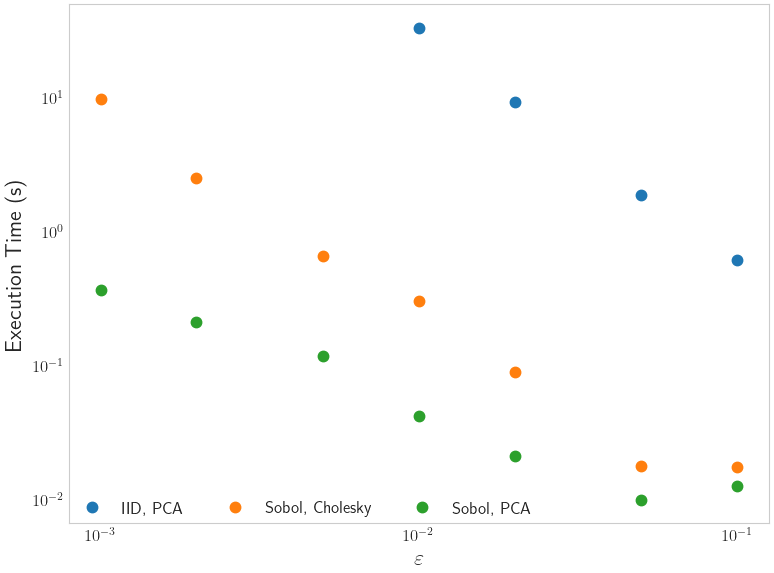

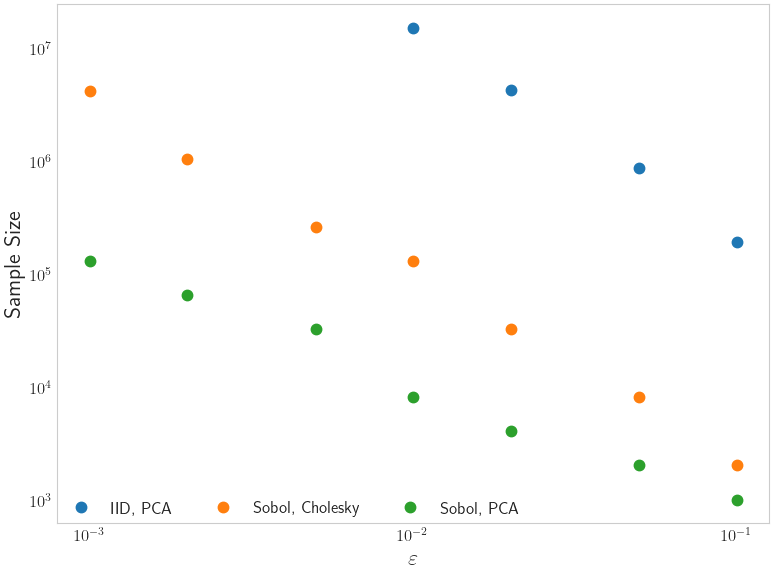

In [21]:
#plot execution times vs tolerance
fig, ax = plt.subplots()
ax.loglog(tol_list,exec_time_PCA_IID,'.', markersize = 15, label = f"IID, PCA")
ax.loglog(tol_list,exec_time_Chol,'.', markersize = 15, label = f"Sobol, Cholesky")
ax.loglog(tol_list,exec_time_PCA,'.', markersize = 15, label = f"Sobol, PCA")
ax.set_xlabel(f"$\\varepsilon$",fontsize=16)
ax.set_ylabel(f"Execution Time (s)",fontsize=16)
#ax.set_ylim([0.001,1e1])
ax.legend(loc='lower left', ncol = 3, frameon = False)
ax.grid(False)
plt.subplots_adjust(top=0.95, right=0.95)
if savefigs:
        fig.savefig(figpath+f"Times_Asian_Option_tol_{tol_list[-1]}_d{d}."+imgfrmt,format=imgfrmt)

#plot number of samples
fig, ax = plt.subplots()
ax.loglog(tol_list,n_PCA_IID,'.', markersize = 15, label = f"IID, PCA")
ax.loglog(tol_list,n_Chol,'.', markersize = 15, label = f"Sobol, Cholesky")
ax.loglog(tol_list,n_PCA,'.', markersize = 15, label = f"Sobol, PCA")
ax.set_xlabel(f"$\\varepsilon$",fontsize=16)
ax.set_ylabel(f"Sample Size",fontsize=16)
#ax.set_ylim([0.001,1e1])
ax.legend(loc='lower left', ncol = 3, frameon = False)
ax.grid(False)
plt.subplots_adjust(top=0.95, right=0.95)
if savefigs:
        fig.savefig(figpath+f"NumSamples_Asian_Option_tol_{tol_list[-1]}_d{d}."+imgfrmt,format=imgfrmt)
